In [1]:
%load_ext autoreload
%autoreload 2

import os
import gc
import sys
import torch
import shutil
import dotenv
import kagglehub

import numpy as np
import seaborn as sns
import torchvision as tv
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm

from dataclasses import dataclass

from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torcheval.metrics import (
    MulticlassAccuracy,
    MulticlassConfusionMatrix,
    MulticlassRecall,
    MulticlassPrecision,
)

from safetensors.torch import save_model
from common import evaluate_multi_classification_model
from common import train_model, initialize_weights
from common import confusion_matrix
from common import plot_trend

from dev_config import DatasetConfig, TrainingConfig

dotenv.load_dotenv()

True

## Image Classification for detecting Covid-19

This COVID-19, normal and other lung infection dataset is released in stages. In the first release we have released 219 COVID-19, 1341 normal and 1345 viral pneumonia chest X-ray (CXR) images. In the first update, we have increased the COVID-19 class to 1200 CXR images. In the 2nd update, we have increased the database to 3616 COVID-19 positive cases along with 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection) and 1345 Viral Pneumonia images.

> Dataset Link:
> https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/data

In [2]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_default_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Download and Extract the Dataset

In [3]:
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

if os.path.exists(f"{path}/COVID-19_Radiography_Dataset/COVID/masks"):
    shutil.rmtree(f"{path}/COVID-19_Radiography_Dataset/COVID/masks")
if os.path.exists(f"{path}/COVID-19_Radiography_Dataset/Lung_Opacity/masks"):
    shutil.rmtree(f"{path}/COVID-19_Radiography_Dataset/Lung_Opacity/masks")
if os.path.exists(f"{path}/COVID-19_Radiography_Dataset/Normal/masks"):
    shutil.rmtree(f"{path}/COVID-19_Radiography_Dataset/Normal/masks")
if os.path.exists(f"{path}/COVID-19_Radiography_Dataset/Viral Pneumonia/masks"):
    shutil.rmtree(f"{path}/COVID-19_Radiography_Dataset/Viral Pneumonia/masks")

dataset = tv.datasets.ImageFolder(f"{path}/COVID-19_Radiography_Dataset")

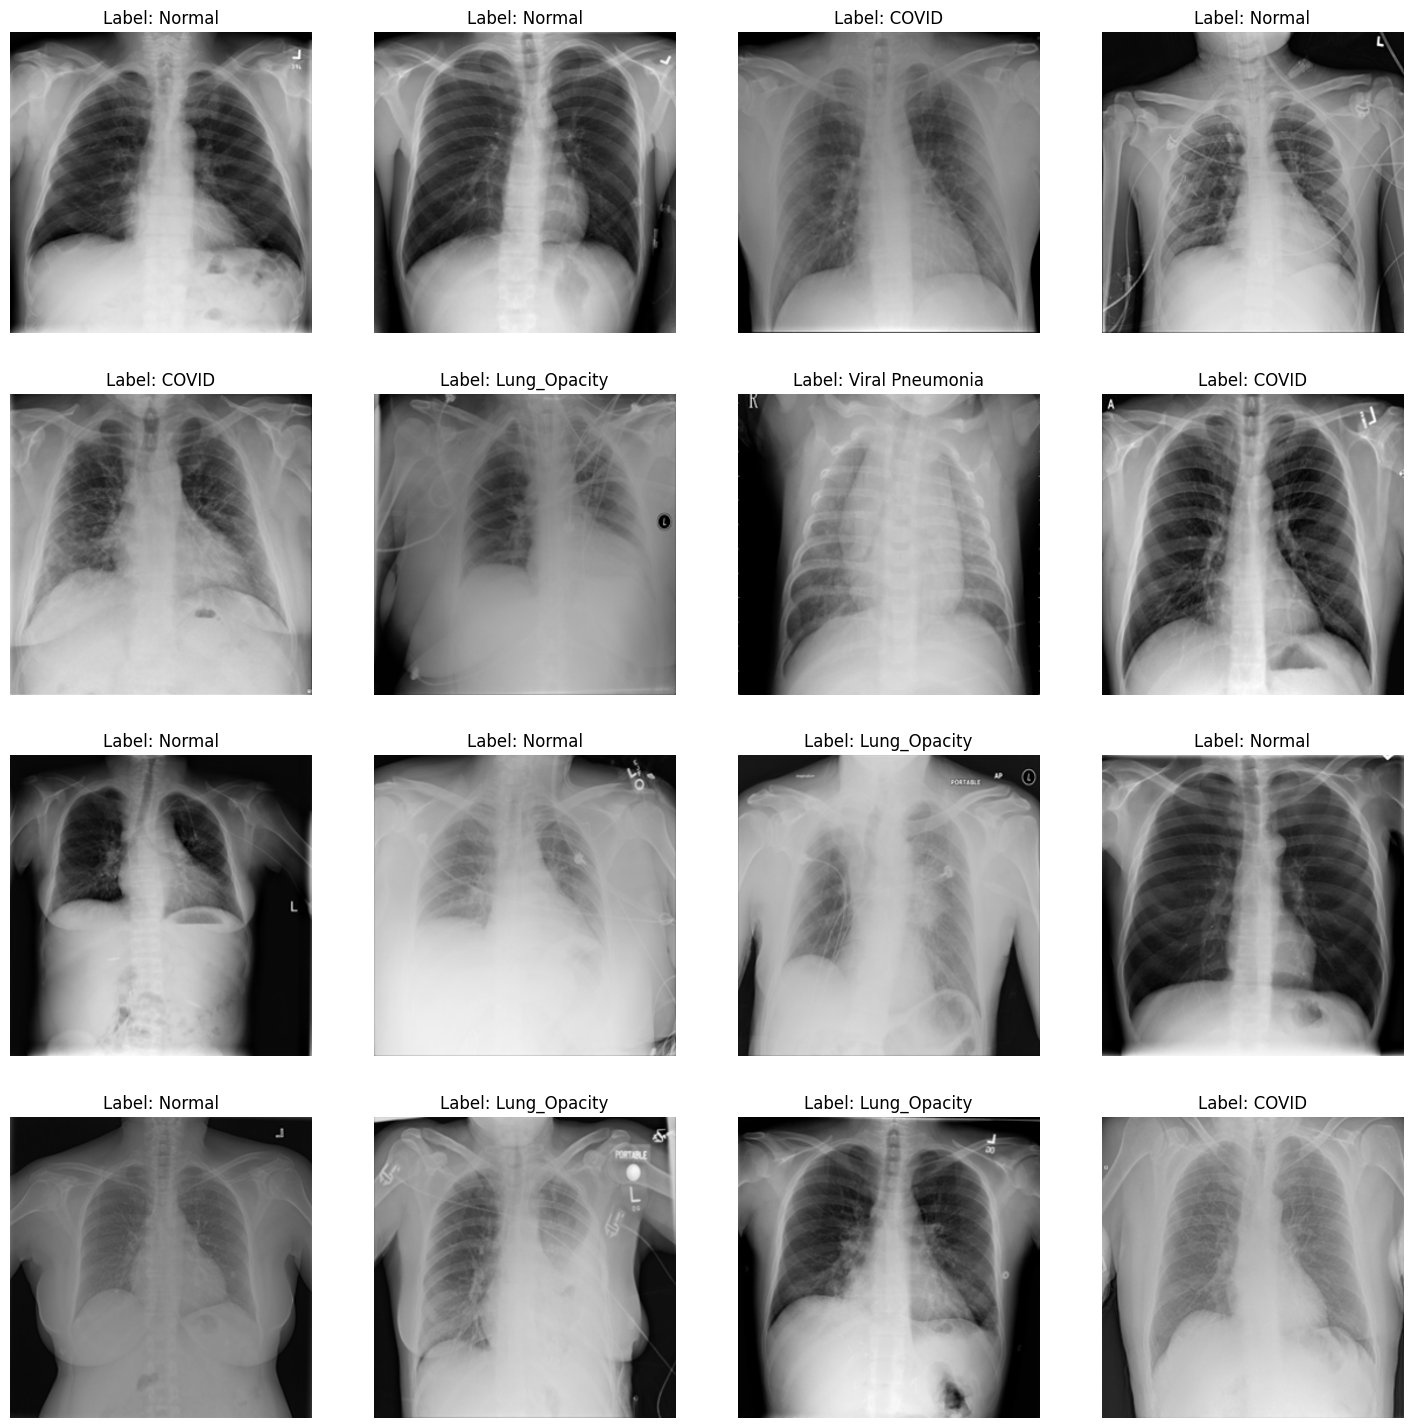

In [4]:
plt.subplots(4, 4, figsize=(18, 18))
for i in range(0, 16, 2):
    plt.subplot(4, 4, i + 1)
    j = np.random.randint(0, len(dataset))
    plt.title(f"Label: {dataset.classes[dataset[j][1]]}")
    plt.imshow(dataset[j][0])
    plt.axis("off")
    plt.subplot(4, 4, i + 2)
    j = np.random.randint(0, len(dataset))
    plt.title(f"Label: {dataset.classes[dataset[j][1]]}")
    plt.imshow(dataset[j][0])
    plt.axis("off")
plt.show()

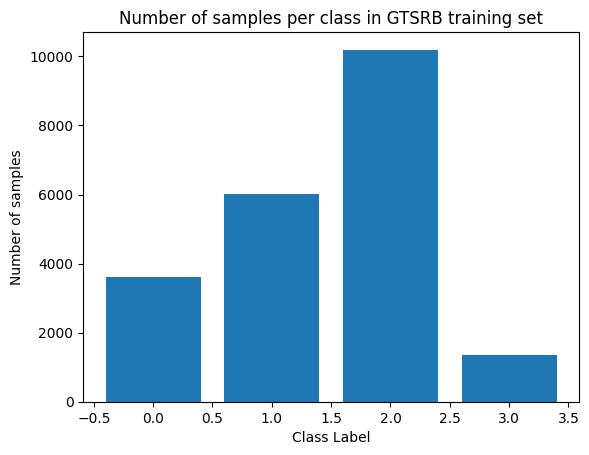

In [5]:
freq = np.bincount([label for _, label in dataset])
weights = torch.tensor(
    np.sum(freq) / (len(dataset.classes) * freq), dtype=torch.float32
)

plt.bar(np.arange(len(freq)), freq)
plt.xlabel("Class Label")
plt.ylabel("Number of samples")
plt.title("Number of samples per class in GTSRB training set")
plt.show()

## Prepare Dataset

In [6]:
def get_preprocess_transforms(resize_to=(256, 256)):
    transforms = v2.Compose(
        [
            v2.Resize(resize_to),
            v2.ToImage(),
            v2.PILToTensor(),
            v2.ToDtype(torch.float32, scale=True),
        ]
    )
    return transforms

In [7]:
def get_common_transforms(
    resize_to, mean=DatasetConfig.IMAGENET_MEAN, std=DatasetConfig.IMAGENET_STD
):
    preprocess = get_preprocess_transforms(resize_to=resize_to)

    common_transforms = v2.Compose([preprocess, v2.Normalize(mean, std)])

    return common_transforms

In [8]:
def get_mean_std(dataset, resize_to=(32, 32), batch_size=128, num_workers=4):

    pre_transforms = get_preprocess_transforms(resize_to=resize_to)
    dataset.transform = pre_transforms
    data_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    batch_mean = torch.zeros(DatasetConfig.CHANNELS)
    batch_mean_sq = torch.zeros(DatasetConfig.CHANNELS)

    for batch_data, _ in tqdm(
        iterable=data_loader,
        ascii=True,
        total=len(data_loader),
        desc="Computing MEAN & STD",
    ):
        batch_mean += torch.mean(batch_data, dim=(0, 2, 3))
        batch_mean_sq += torch.mean(batch_data**2, dim=(0, 2, 3))

    mean = batch_mean / len(data_loader)
    # var[X] = E[X**2] - E[X]**2
    var = (batch_mean_sq / len(data_loader)) - (mean**2)
    std = var**0.5

    print("Mean: {}, Std: {}".format(mean, std))

    return mean, std

In [9]:
def get_aug_transforms():
    return v2.RandomChoice(
        [
            v2.RandomAffine(degrees=(-25, 25)),
            v2.RandomAffine(translate=(0.2, 0.2), degrees=(0, 0)),
            v2.RandomAffine(scale=(0.90, 1.1), degrees=(0, 0)),
        ]
    )

In [10]:
def get_data(
    dataset,
    resize_to=(32, 32),
    batch_size=32,
    split_lengths=(0.7, 0.15, 0.15),
    data_augmentation=False,
    num_workers=0,
):

    MEAN = 0
    STD = 1

    MEAN, STD = get_mean_std(dataset, resize_to=resize_to, num_workers=2)

    common_transforms = get_common_transforms(resize_to=resize_to, mean=MEAN, std=STD)

    if data_augmentation:

        transforms = v2.Compose(
            [
                common_transforms,
                get_aug_transforms(),
            ]
        )
    else:
        transforms = common_transforms

    train_dataset, valid_dataset, tests_dataset = torch.utils.data.random_split(
        dataset, lengths=split_lengths
    )

    train_dataset.transform = transforms  # type: ignore
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    valid_dataset.transform = transforms  # type: ignore
    valid_dataloader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    tests_dataset.transform = transforms  # type: ignore
    tests_dataloader = DataLoader(
        tests_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    return train_dataloader, valid_dataloader, tests_dataloader

In [11]:
train_dataloader, valid_dataloader, test_dataloader = get_data(
    dataset,
    resize_to=(DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
    batch_size=TrainingConfig.BATCH_SIZE,
    num_workers=TrainingConfig.NUM_WORKERS,
    data_augmentation=False,
)

Computing MEAN & STD: 100%|##########| 166/166 [00:24<00:00,  6.73it/s]

Mean: tensor([0.5093, 0.5093, 0.5093]), Std: tensor([0.2521, 0.2521, 0.2521])


## Detector Net Model

For this dataset we use two pretrained models resnet34 and efficient b4 which enable us to leverage the features learned and apply it to another domain.

In [12]:
class DetectorNet(torch.nn.Module):

    def __init__(self, model, freeze_up_to=-3, hidden_feat=512):
        super().__init__()
        params = list(model.children())
        for param in params[:freeze_up_to]:
            param.require_grad = False
        self.backbone = torch.nn.Sequential(*params[:-1])
        self.flatten = torch.nn.Flatten()
        self.mlp = tv.ops.MLP(in_channels=hidden_feat, hidden_channels=[256, 128])
        self.head = torch.nn.Linear(128, 4)

    def forward(self, x):
        x = self.backbone(x)
        x = self.flatten(x)
        x = self.mlp(x)
        x = self.head(x)
        return x

In [13]:
backbone0 = tv.models.resnet34(
    weights=tv.models.ResNet34_Weights.IMAGENET1K_V1, progress=False
)

print(summary(DetectorNet(model=backbone0), input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                        Output Shape              Param #
DetectorNet                                   [32, 4]                   --
├─Sequential: 1-1                             [32, 512, 1, 1]           --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        128
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [32, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-2                   [32, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-3                   [32, 64, 56, 56]          73,984
│    └─Sequential: 2-6                        [32, 128, 28, 28]         --
│    │    └─BasicBlock: 3-4                   [32, 128, 28, 28]         230,144

### ResNet34

In [14]:
device = get_default_device()

backbone1 = tv.models.resnet34(
    weights=tv.models.ResNet34_Weights.IMAGENET1K_V1, progress=False
)
model = DetectorNet(model=backbone1, freeze_up_to=-5)
model.apply(initialize_weights)

optim = torch.optim.Adam(
    model.parameters(),
    lr=TrainingConfig.LEARNING_RATE,
)
criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optim,
    max_lr=TrainingConfig.LEARNING_RATE,
    steps_per_epoch=len(train_dataloader),
    epochs=TrainingConfig.EPOCHS,
)
early_stopping = None
train_metrics = [
    MulticlassAccuracy(average="macro", num_classes=DatasetConfig.NUM_CLASSES)
]

valid_metrics = [
    MulticlassAccuracy(average="macro", num_classes=DatasetConfig.NUM_CLASSES)
]

train_results, valid_results = train_model(
    model,
    TrainingConfig(),
    optim,
    criterion,
    scheduler,
    train_dataloader,
    valid_dataloader,
    device.type,
    early_stopping=early_stopping,
    train_metrics=train_metrics,
    valid_metrics=valid_metrics,
    break_after_it=TrainingConfig.BREAK_AFTER_IT,
    checkpoint_path=os.path.join(TrainingConfig.ROOT_DIR, "models"),
    model_name=DetectorNet.__name__ + "_ResNet.checkpoint",
)

save_model(
    model,
    os.path.join(
        TrainingConfig.ROOT_DIR,
        "models",
        DetectorNet.__name__ + "_ResNet_last.safetensors",
    ),
)

Training Progress:   0%|          | 0/5625 [00:00<?, ?it/s]/Users/jmanuelc87/Documents/Projects/advanced-cv/.venv/lib/python3.13/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:234.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")
Training Progress: 100%|██████████| 5625/5625 [09:37<00:00,  9.75it/s, epoch=5, loss=0.0051, val_loss=0.2056, ValidMulticlassAccuracy=0.8371, lr=0.000000]


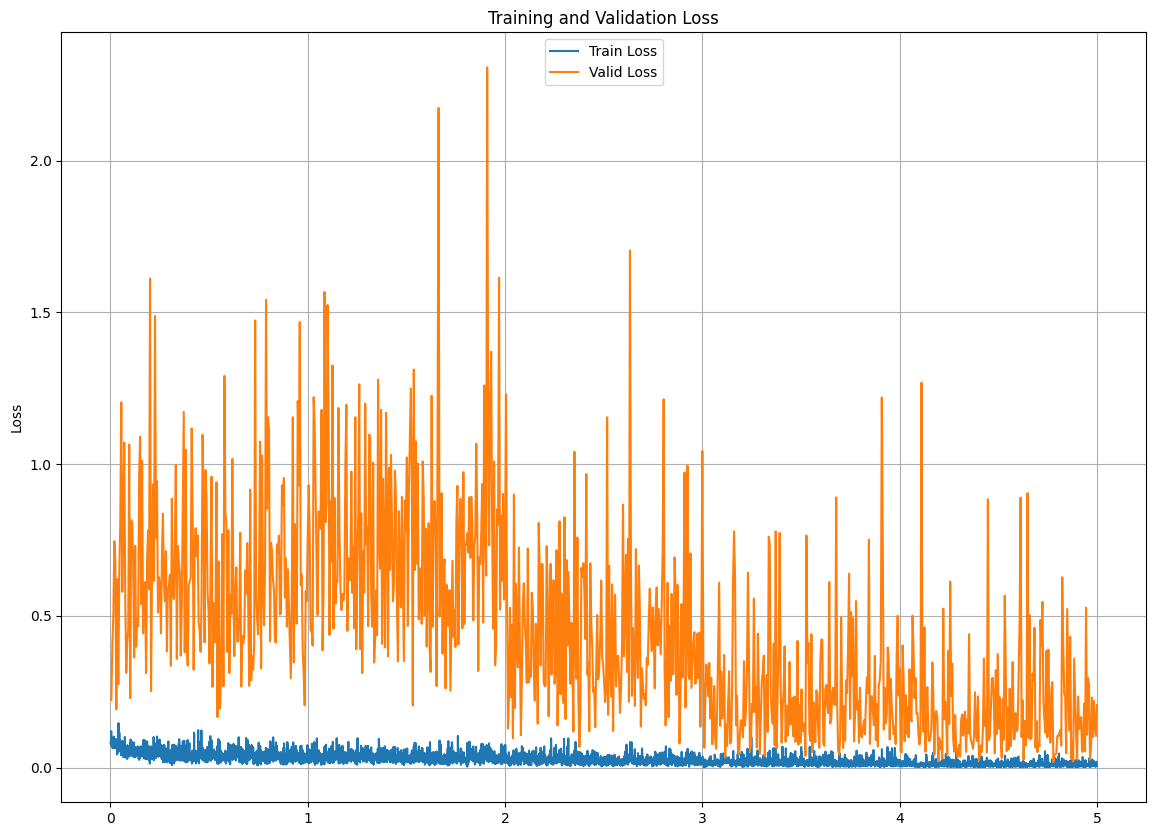

In [15]:
results1 = np.array(train_results)
results2 = np.array(valid_results)

plot_trend(
    trends=[results1[:, :2], results2[:, :2]],
    labels=["Train Loss", "Valid Loss"],
    title="Training and Validation Loss",
    axis="Loss",
)

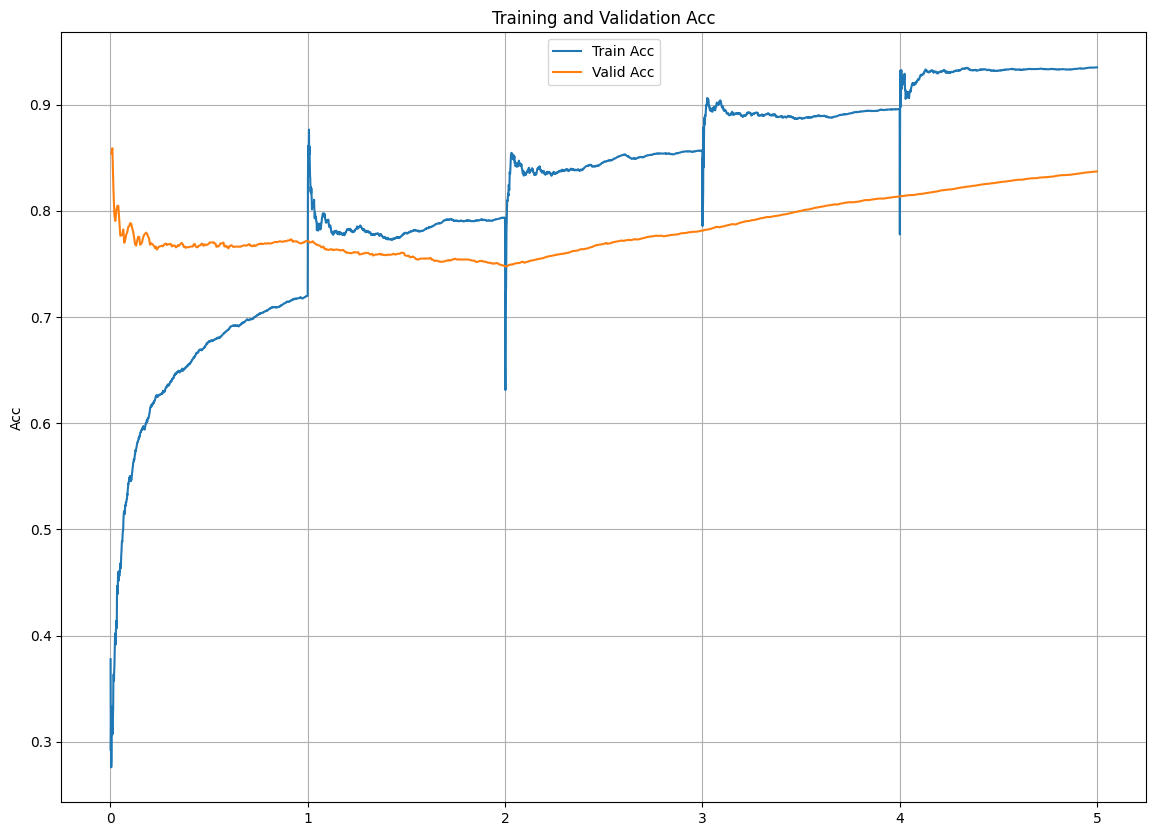

In [16]:
col_idx = [0, 2]

plot_trend(
    trends=[results1[:, col_idx], results2[:, col_idx]],
    labels=["Train Acc", "Valid Acc"],
    title="Training and Validation Acc",
    axis="Acc",
)

In [17]:
acc1, recall1, precision1, f11 = evaluate_multi_classification_model(
    num_classes=4, model=model, dataloader=test_dataloader, device=device
)

print(f"Accuracy: {acc1}, Recall: {recall1}, Precision: {precision1}, F1 score: {f11}")

Accuracy: 0.9285383820533752, Recall: 0.9285383820533752, Precision: 0.9085917472839355, F1 score: 0.9181050658226013


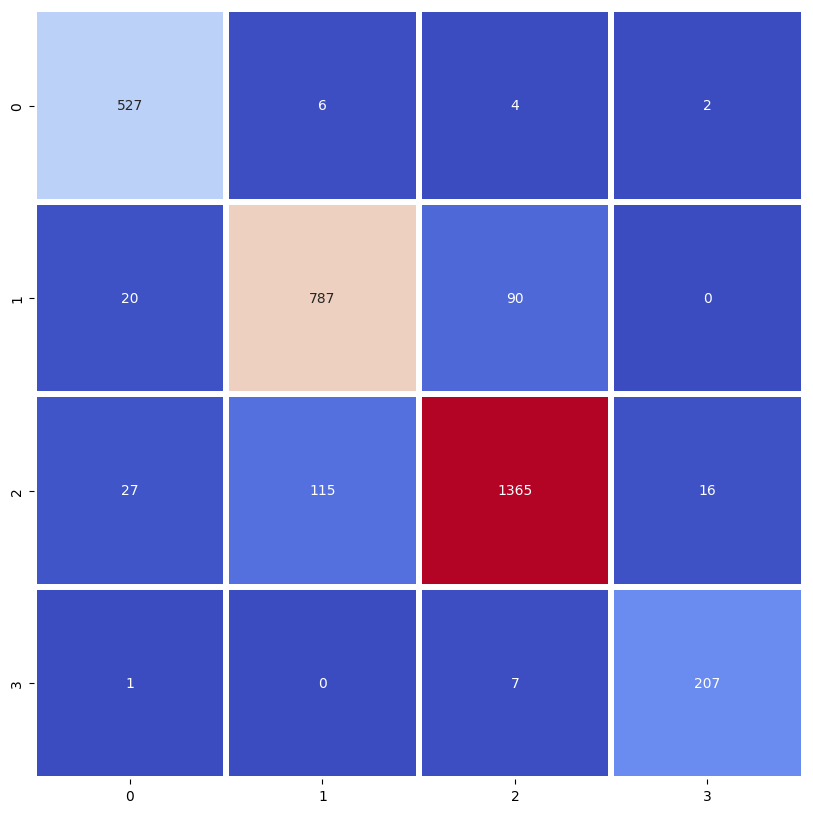

In [18]:
confusion_matrix(
    num_classes=4, model=model, dataloader=test_dataloader, device=device
)

### EfficientNet B4

In [19]:
train_dataloader1, valid_dataloader1, test_dataloader1 = get_data(
    dataset,
    resize_to=(DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
    batch_size=TrainingConfig.BATCH_SIZE,
    num_workers=TrainingConfig.NUM_WORKERS,
    data_augmentation=False,
)

Computing MEAN & STD: 100%|##########| 166/166 [00:26<00:00,  6.29it/s]

Mean: tensor([0.5093, 0.5093, 0.5093]), Std: tensor([0.2521, 0.2521, 0.2521])


In [20]:
backbone2 = tv.models.efficientnet_b4(
    weights=tv.models.EfficientNet_B4_Weights.IMAGENET1K_V1
)
model1 = DetectorNet(model=backbone2, hidden_feat=1792, freeze_up_to=-5)
model1.apply(initialize_weights)

optim1 = torch.optim.Adam(
    model1.parameters(),
    lr=TrainingConfig.LEARNING_RATE,
)
criterion1 = torch.nn.CrossEntropyLoss(weight=weights.to(device))
scheduler1 = torch.optim.lr_scheduler.OneCycleLR(
    optim1,
    max_lr=TrainingConfig.LEARNING_RATE,
    steps_per_epoch=len(train_dataloader),
    epochs=TrainingConfig.EPOCHS,
)
early_stopping1 = None
train_metrics1 = [
    MulticlassAccuracy(average="macro", num_classes=DatasetConfig.NUM_CLASSES)
]

valid_metrics1 = [
    MulticlassAccuracy(average="macro", num_classes=DatasetConfig.NUM_CLASSES)
]

train_results1, valid_results1 = train_model(
    model1,
    TrainingConfig(),
    optim1,
    criterion1,
    scheduler1,
    train_dataloader1,
    valid_dataloader1,
    get_default_device().type,
    early_stopping=early_stopping1,
    train_metrics=train_metrics1,
    valid_metrics=valid_metrics1,
    break_after_it=TrainingConfig.BREAK_AFTER_IT,
    checkpoint_path=os.path.join(TrainingConfig.ROOT_DIR, "models"),
    model_name=DetectorNet.__name__ + "_EfficientNet.checkpoint",
)

save_model(
    model,
    os.path.join(
        TrainingConfig.ROOT_DIR,
        "models",
        DetectorNet.__name__ + "_EfficientNet_last.safetensors",
    ),
)

Training Progress: 100%|██████████| 5625/5625 [26:58<00:00,  3.48it/s, epoch=5, loss=0.0115, val_loss=0.0952, ValidMulticlassAccuracy=0.8467, lr=0.000000]


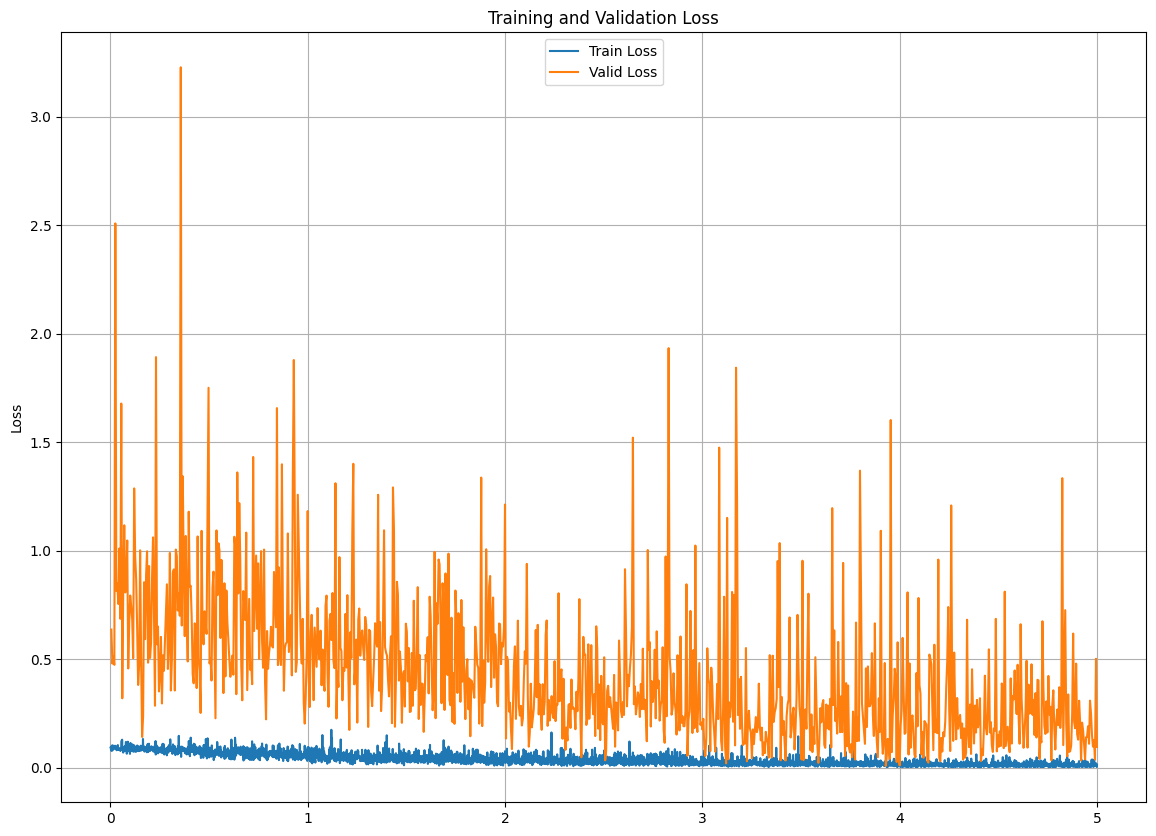

In [21]:
results11 = np.array(train_results1)
results21 = np.array(valid_results1)

plot_trend(
    trends=[results11[:, :2], results21[:, :2]],
    labels=["Train Loss", "Valid Loss"],
    title="Training and Validation Loss",
    axis="Loss",
)

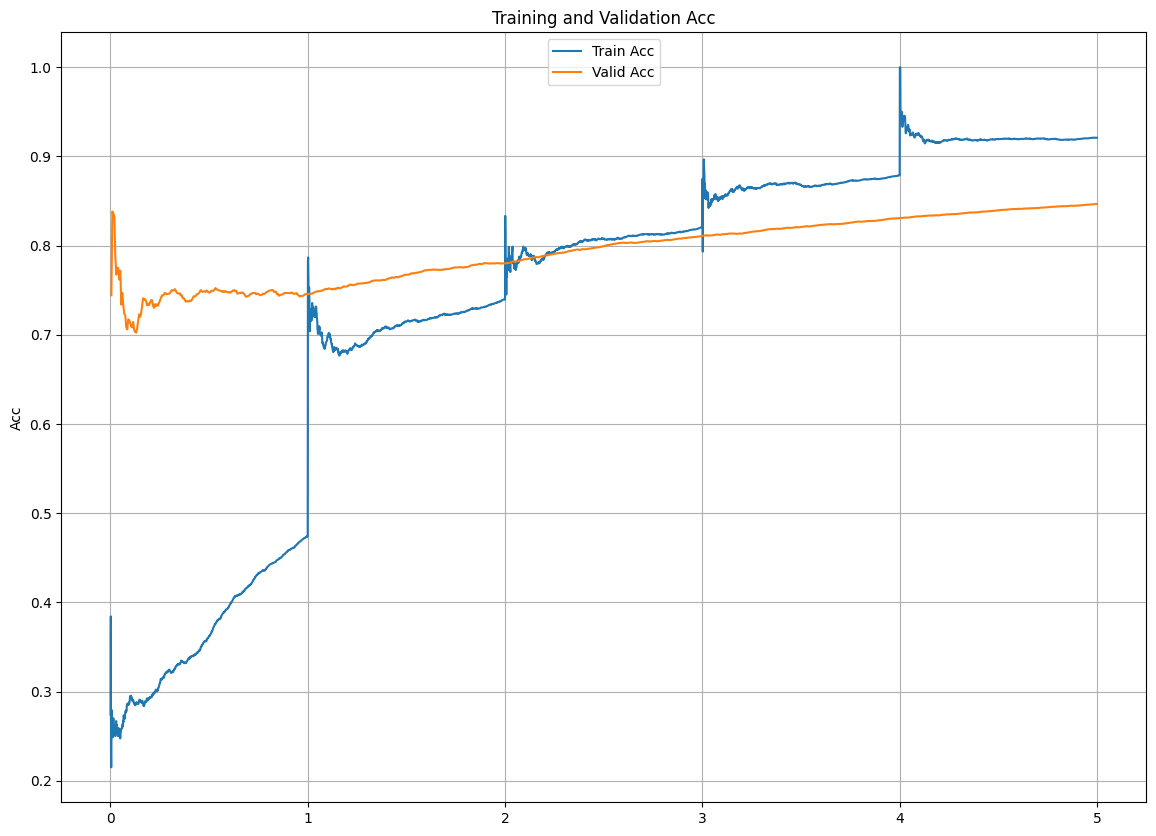

In [22]:
col_idx1 = [0, 2]

plot_trend(
    trends=[results11[:, col_idx1], results21[:, col_idx1]],
    labels=["Train Acc", "Valid Acc"],
    title="Training and Validation Acc",
    axis="Acc",
)

In [23]:
acc2, recall2, precision2, f12 = evaluate_multi_classification_model(
    num_classes=4, model=model1, dataloader=test_dataloader1, device=device
)

print(f"Accuracy: {acc2}, Recall: {recall2}, Precision: {precision2}, F1 score: {f12}")

Accuracy: 0.9212777614593506, Recall: 0.9212777614593506, Precision: 0.9002889394760132, F1 score: 0.9101832509040833


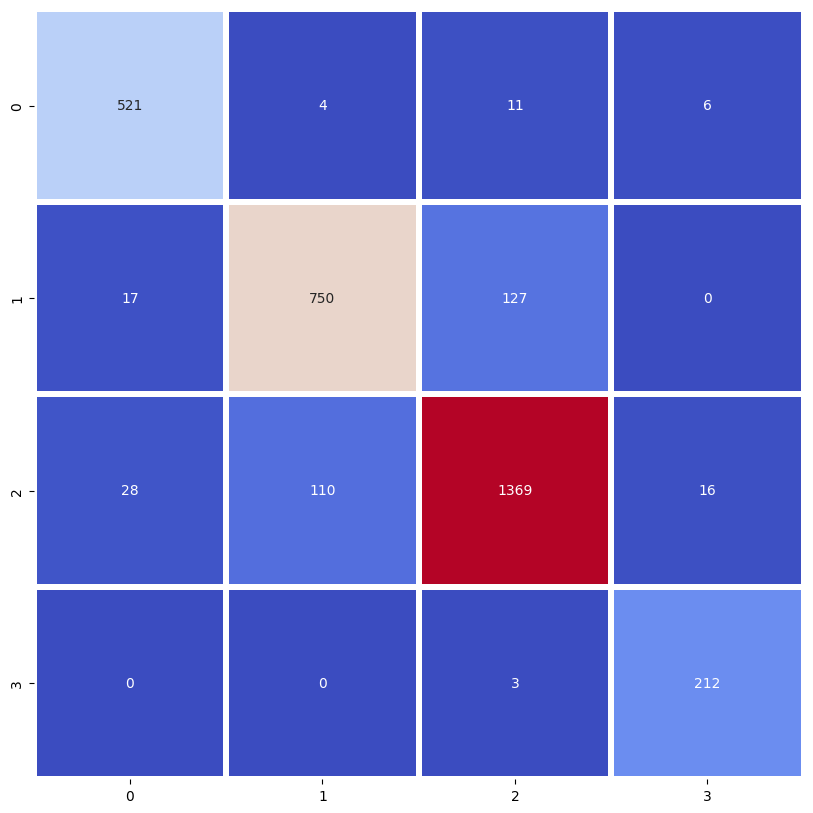

In [24]:
confusion_matrix(
    num_classes=4, model=model1, dataloader=test_dataloader1, device=device
)